# Build an Image Segmentation Model for Medical Diagnosis using CNN, PyTorch and OpenCV

## Introduction

In healthcare and medical science, the fusion of artificial intelligence and deep learning is revolutionizing diagnostics. My project focuses on the precise segmentation of polyps from colonoscopy images—a vital tool for medical practitioners.

In this project, we aim to develop an image segmentation model using CNN and deploy it with PyTorch.

### Install dependencies

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import os
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch
import torch.nn as nn
from torch import nn
import torch.optim as optim
import torch.utils.data

from argparse import ArgumentParser
from collections import OrderedDict
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# https://github.com/albumentations-team/albumentations/tree/main/albumentations
from albumentations import Resize
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import HueSaturationValue, Normalize
from albumentations.augmentations.geometric import transforms
from albumentations.augmentations.geometric.transforms import Flip
from albumentations.augmentations.geometric.rotate import RandomRotate90

from ml_deploy.network import UNetPP
from ml_deploy.dataset import DataSet
from ml_deploy.train import train
from ml_deploy.validate import validate


## set up config
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)

extn = config["extn"]
epochs = config["epochs"]
log_path = config["log_path"]
mask_path = config["mask_path"]
image_path = config["image_path"]
model_path = config["model_path"]
im_width = config["im_width"]
im_height = config["im_height"]
model_path = config["model_path"]
output_path = config["output_path"]
best_iou, trigger = 0, 0

## Data Preparation

Load the image dataset and create train and validation datasets

In [4]:
## define dataset class for transformaion
class DataSet(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img = cv2.imread(os.path.join(self.img_dir, img_id + self.img_ext))
        mask = []
        mask.append(cv2.imread(os.path.join(self.mask_dir, img_id + self.mask_ext), cv2.IMREAD_GRAYSCALE)[..., None])
        mask = np.dstack(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)
        return img, mask, {'img_id': img_id}

In [5]:
## split images into train and validation datasets
extn_ = f"*{extn}"
img_ids = glob(os.path.join('dataset/PNG/Original', extn_))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.2)


## define data transformations using the albumentations library
train_transform = Compose([
    RandomRotate90(),
    transforms.Flip(),
    OneOf([
        HueSaturationValue(),
        # transforms.RandomBrightness(),
        # transforms.RandomContrast(),
    ], p=1),
    Resize(256, 256),
    Normalize(),
])

val_transform = Compose([
    Resize(256, 256), 
    Normalize(),
])

train_dataset = DataSet(
    img_ids=train_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=train_transform
)

val_dataset = DataSet(
    img_ids=val_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=val_transform
)
print('train dataset: ', len(train_dataset.img_ids), train_dataset.img_ids)
print('validation dataset: ', len(val_dataset.img_ids), val_dataset.img_ids)


## create train and validation data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False
)

train dataset:  489 ['114', '382', '477', '439', '587', '76', '447', '542', '7', '352', '365', '354', '53', '12', '109', '171', '41', '483', '167', '261', '346', '568', '180', '377', '543', '69', '21', '211', '348', '358', '492', '119', '236', '479', '367', '47', '68', '438', '285', '583', '517', '561', '521', '560', '54', '456', '388', '194', '499', '545', '550', '48', '589', '610', '448', '313', '340', '35', '32', '83', '25', '232', '142', '185', '14', '537', '474', '237', '159', '469', '485', '538', '569', '228', '2', '600', '481', '405', '219', '259', '339', '368', '434', '326', '455', '470', '413', '170', '93', '412', '345', '355', '379', '112', '30', '454', '360', '108', '420', '225', '446', '366', '408', '502', '571', '279', '28', '231', '426', '150', '31', '214', '299', '501', '562', '151', '555', '505', '4', '507', '487', '107', '101', '511', '70', '418', '409', '496', '515', '248', '576', '286', '57', '422', '287', '37', '223', '183', '391', '321', '96', '599', '146', '158', 

## Model Creation & Training

Create the model object and train with epoch

In [6]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out


class UNetPP(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [5]:
## load the model
model = UNetPP(1, 3, True)


## port the model to GPU if available
if torch.cuda.is_available():
    model.cuda()


## define loss function
criterion = nn.BCEWithLogitsLoss()
params = filter(lambda p: p.requires_grad, model.parameters())


## define optimizer
optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-4)


## create log file
log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])
best_iou, trigger = 0, 0



## run train loop
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs}]')
    # train for one epoch
    train_log = train(True, train_loader, model, criterion, optimizer)
    
    # evaluate on validation set
    val_log = validate(True, val_loader, model, criterion)
    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
                % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv(log_path, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), model_path)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

Epoch [0/100]


 23%|██▎       | 7/30 [21:42<1:07:06, 175.08s/it, loss=0.628, iou=0.144] 

## Prediction

Load the model and predict the segmentation using test images

In [9]:
## load pre-trained weights
model = UNetPP(1, 3, True)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

## port the model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()
    
# set model mode to evaluation
model.eval()

UNetPP(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (c

### Load the test image

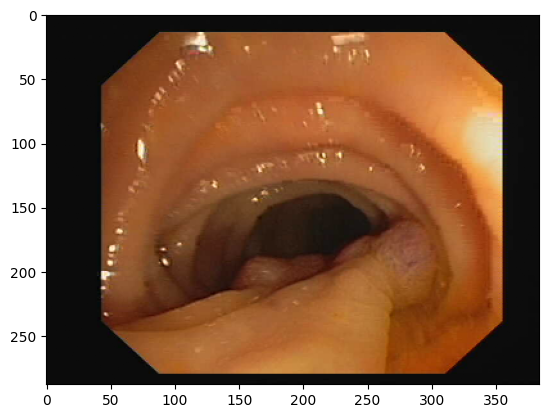

In [15]:
def image_loader(image_name):
    img = imread(image_name)
    img = val_transform(image=img)["image"]
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)
    return img

test_img = "dataset/PNG/Original/20.png"
am = plt.imread(test_img)
plt.imshow(am)

image = image_loader(test_img)

## convert the image to a batch of 1 image
image = np.expand_dims(image, 0)


## convert numpy array to torch tensor
image = torch.from_numpy(image)


## port the image to GPU if available
if torch.cuda.is_available():
    image = image.to(device="cuda")

### Make prediction

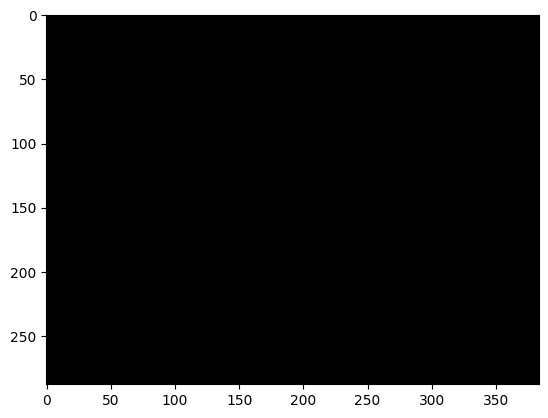

In [11]:
mask = model(image)
mask = mask[-1]


## convert torch tensor to numpy array, then to a 2-d array, and binary form
mask = mask.detach().cpu().numpy()
mask = np.squeeze(np.squeeze(mask, axis=0), axis=0)
mask[mask > -2.5] = 255
mask[mask <= -2.5] = 0
mask = cv2.resize(mask, (im_width, im_height)) # resize the ouptut image to input image size
plt.imshow(mask, cmap="gray")

### Read and plot the ground truth mask

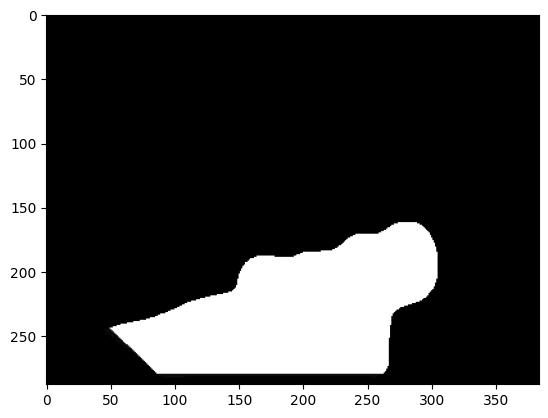

In [16]:
actual_mask = "dataset/PNG/Ground Truth/20.png"
am = plt.imread(actual_mask)
plt.imshow(am, cmap="gray")